# XGBOOST

## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
df= pd.read_csv("final_prepared_data.csv")

In [ ]:
df['Volume'] = np.log1p(df['Volume'])
df['Volume_tomorrow'] = np.log1p(df['Volume_tomorrow'])

In [ ]:


drop_cols = ['level_0', 'index', 'Date']
target_cols = ['Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow',
               'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow']

# Separate features and targets
X_raw = df.drop(columns=drop_cols + target_cols)
y = df[target_cols]

# Identify feature types BEFORE transformation
numeric_features = X_raw.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_raw.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), categorical_features)
    ]
)

# Fit and transform
X_transformed = preprocessor.fit_transform(X_raw)

# Combine numeric + categorical column names
all_feature_names = numeric_features + categorical_features

# Reconstruct DataFrame with feature names
X = pd.DataFrame(X_transformed, columns=all_feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


In [ ]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,high_to_low,close_to_open,daily_range_pct,volume_per_price,Symbol
0,-0.052974,-0.174773,-0.179834,-0.173610,-0.177189,-0.147424,-0.123697,0.697090,-0.123697,-0.810817,-0.318464,-0.831709,-0.285860,24.0
1,-0.087727,-0.176884,-0.179080,-0.172483,-0.176427,-0.146665,-0.123697,-1.434534,-0.123697,-0.856368,0.049336,-0.875614,-0.288440,24.0
2,0.792106,-0.177119,-0.181923,-0.181677,-0.186337,-0.156530,-0.123697,-1.434534,-0.123697,-0.049874,-1.193987,-0.056212,-0.171175,24.0
3,0.839150,-0.186680,-0.188188,-0.186185,-0.189797,-0.159973,-0.123697,-1.434534,-0.123697,-0.280718,-0.417891,-0.282197,-0.159261,24.0
4,0.394491,-0.185038,-0.182561,-0.179779,-0.179652,-0.149875,-0.123697,-1.434534,-0.123697,-0.376939,0.693218,-0.372260,-0.241042,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127882,1.541929,0.125673,0.120526,0.113056,0.104882,0.133336,1.773458,0.697090,1.773458,0.622811,-1.683094,0.621176,-0.059746,3.0
127883,1.426233,0.120628,0.122847,0.124978,0.130919,0.159252,1.231414,0.697090,1.231414,-0.161498,0.832756,-0.153105,-0.106411,3.0
127884,1.200097,0.134354,0.127024,0.130495,0.129101,0.157443,1.231414,0.697090,1.231414,-0.267506,-0.423384,-0.275214,-0.165372,3.0
127885,1.425867,0.131949,0.145300,0.140044,0.151444,0.179682,0.892636,0.697090,0.892636,0.428741,1.559160,0.470568,-0.112306,3.0


## Model

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=.3, random_state=42)

multi_xgb = MultiOutputRegressor(xgb)

multi_xgb.fit(X_train, y_train)

y_pred = multi_xgb.predict(X_test)

for i, col in enumerate(y_train.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col} - MSE: {mse:.4f}, R2: {r2:.4f}")


Volume_tomorrow - MSE: 0.1186, R2: 0.9286
Open_tomorrow - MSE: 245.0506, R2: 0.9917
High_tomorrow - MSE: 274.5939, R2: 0.9909
Low_tomorrow - MSE: 269.1345, R2: 0.9907
Close_tomorrow - MSE: 260.2326, R2: 0.9912
Adj close_tomorrow - MSE: 260.2055, R2: 0.9913


In [ ]:
import math
rmse = math.sqrt(mse)
rmse

16.130888042814103

In [ ]:
import math

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print("\nOverall Test Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# Calculate and print metrics for each target separately
print("\nMetrics for individual targets:")
for i, col in enumerate(y_test.columns):
    mse_i = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2_i = r2_score(y_test.iloc[:, i], y_pred[:, i])
    rmse_i = math.sqrt(mse_i)

    print(f"{col}:")
    print(f"  MSE: {mse_i:.4f}")
    print(f"  RMSE: {rmse_i:.4f}")
    print(f"  R²: {r2_i:.4f}")

    # For Volume, transform back to original scale to see actual error
    if col == 'Volume_tomorrow':
        # Clip values to prevent inf
        y_test_orig = np.expm1(np.clip(y_test.iloc[:, i], -100, 100)) # clip log-transformed data to range
        y_pred_orig = np.expm1(np.clip(y_pred[:, i], -100, 100)) # clip log-transformed data to range


        mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
        rmse_orig = math.sqrt(mse_orig)
        print(f"  Original scale RMSE: {rmse_orig:.4f}")


Overall Test Metrics:
MSE: 218.2226
RMSE: 14.7724
R-squared: 0.9807

Metrics for individual targets:
Volume_tomorrow:
  MSE: 0.1186
  RMSE: 0.3443
  R²: 0.9286
  Original scale RMSE: 9393868.8102
Open_tomorrow:
  MSE: 245.0506
  RMSE: 15.6541
  R²: 0.9917
High_tomorrow:
  MSE: 274.5939
  RMSE: 16.5709
  R²: 0.9909
Low_tomorrow:
  MSE: 269.1345
  RMSE: 16.4053
  R²: 0.9907
Close_tomorrow:
  MSE: 260.2326
  RMSE: 16.1317
  R²: 0.9912
Adj close_tomorrow:
  MSE: 260.2055
  RMSE: 16.1309
  R²: 0.9913


##XAI Techniques

###  Visualize predictions vs actual values


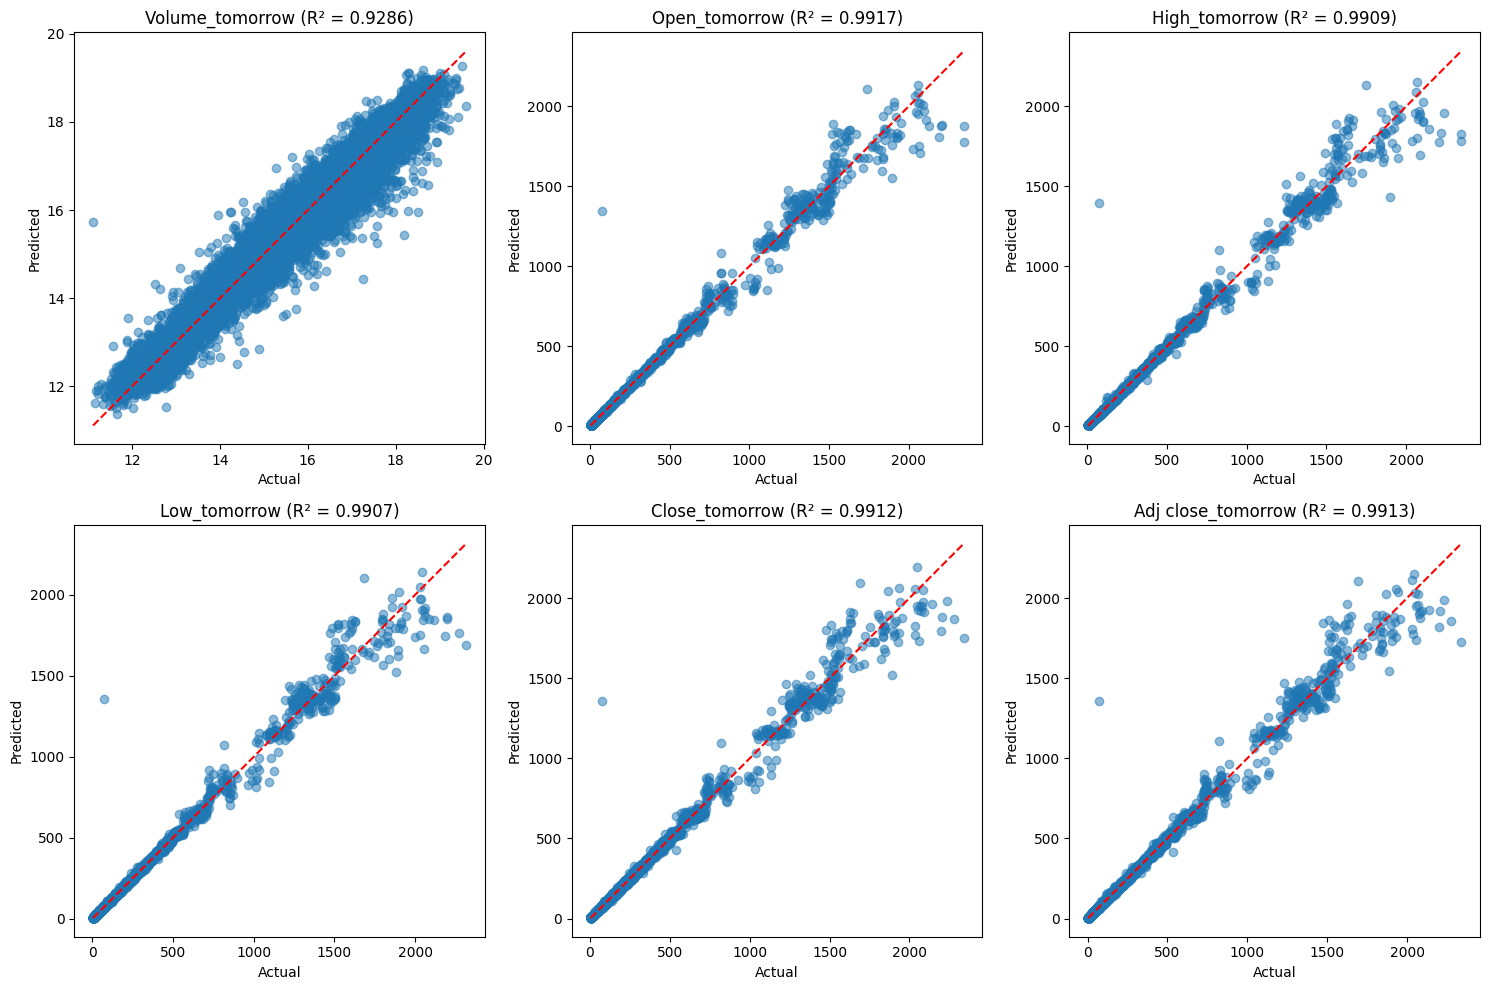

In [ ]:
import matplotlib.pyplot as plt
# Visualize predictions vs actual values
plt.figure(figsize=(15, 10))
for i, col in enumerate(y_test.columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{col} (R² = {r2_score(y_test.iloc[:, i], y_pred[:, i]):.4f})')
plt.tight_layout()
plt.savefig('prediction_results.png')
plt.show()

### Feature Importance

In [ ]:

feature_importances = []
for i in range(len(y_test.columns)):
    importance = multi_xgb.estimators_[i].feature_importances_
    feature_importances.append(importance)
feature_importance_df = pd.DataFrame(
    np.array(feature_importances).T,
    columns=y_test.columns
)


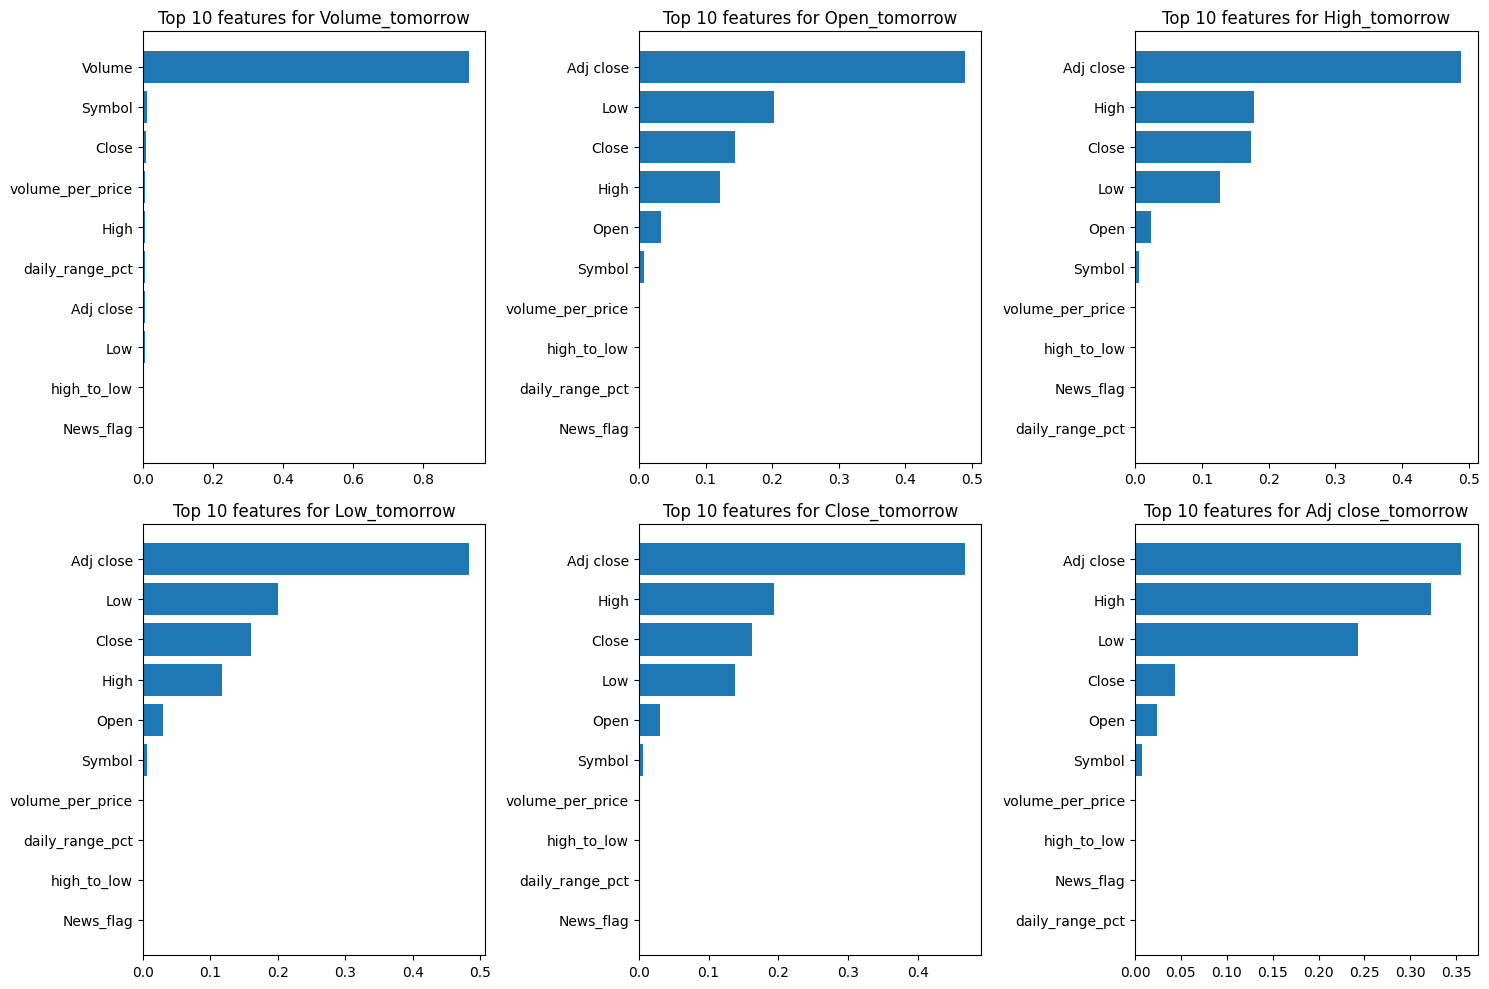

In [79]:
feature_names = X.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_importance_df.columns):
    plt.subplot(2, 3, i+1)
    sorted_idx = feature_importance_df[col].argsort()
    top_features = sorted_idx[-10:]
    plt.barh(range(10), feature_importance_df.iloc[top_features, i])
    plt.yticks(range(10), [feature_names[idx] for idx in top_features])
    plt.title(f'Top 10 features for {col}')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


### Lime

In [80]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4e80e7fd2a2b02dde0cd789df06b83a5d4395f157a28befa86ebbe9744b659f1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [81]:


import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=y_train.columns.tolist(),
    mode='regression'
)

instance_idx = 0
instance = X_test.iloc[instance_idx]


# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=multi_xgb.predict,
    num_features=10 # Number of top features to display
)





In [83]:
# Show the explanation
exp.show_in_notebook(show_table=True)





In [84]:
explanation_data = exp.as_list()
print(explanation_data)


[('Volume > 0.65', 1.623597921036569), ('Close > 0.12', -0.7554598247557717), ('Open > 0.12', 0.2570620873577171), ('Low > 0.12', 0.17705379155132553), ('12.00 < Symbol <= 24.00', -0.15842219666008886), ('-0.47 < close_to_open <= 0.01', -0.1276951724147102), ('-0.26 < volume_per_price <= -0.10', 0.0979945584396749), ('Adj close > 0.11', 0.09143042602670326), ('high_to_low > 0.30', -0.057169820316471914), ('Scaled_sentiment <= -0.58', -0.05266046948012015)]


### SHAP

In [85]:
!pip install shap


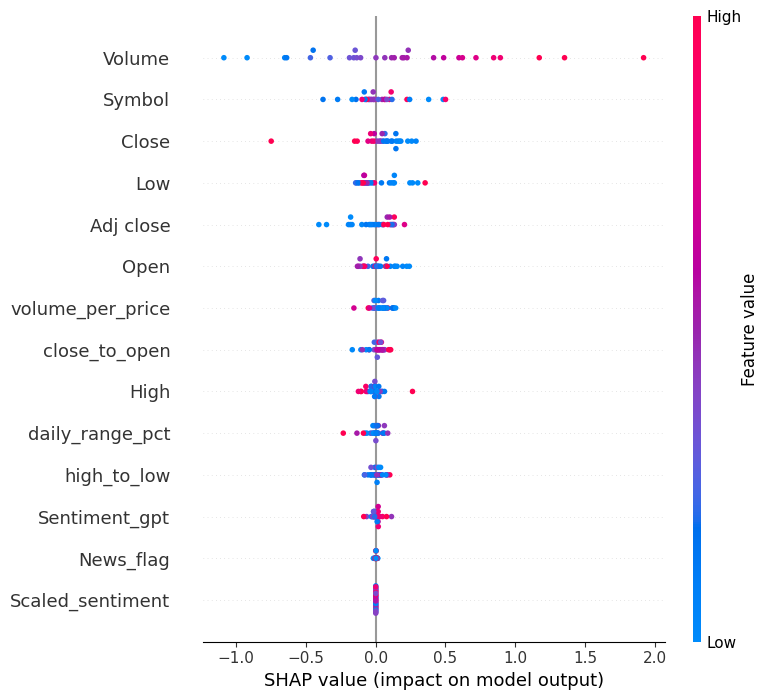

In [93]:

import shap


X_test_sample = X_test.sample(n=30, random_state=42)

def predict_fn(X):
    return multi_xgb.predict(X)

explainer = shap.Explainer(multi_xgb.estimators_[0], X_train)

shap_values = explainer(X_test_sample)

shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=True)



Summary plot for target: Volume_tomorrow


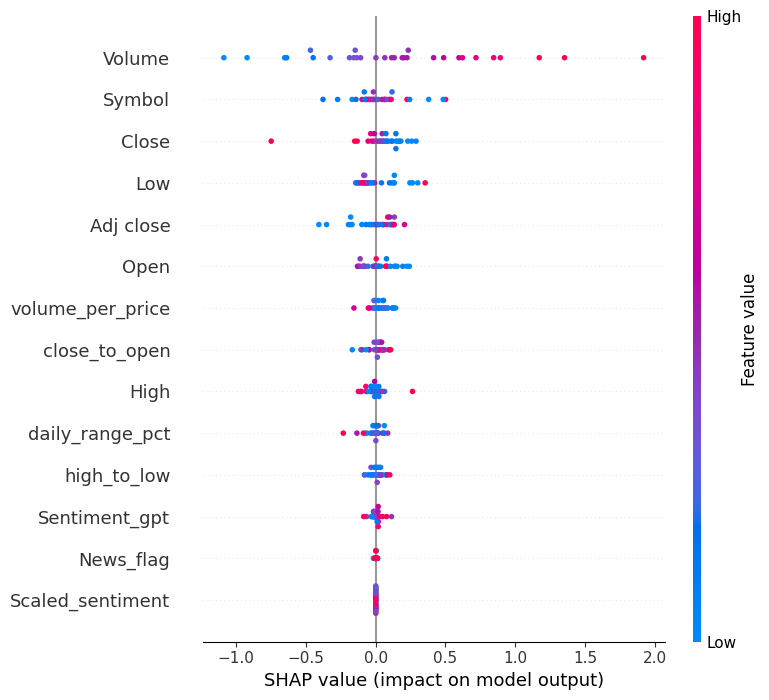


Summary plot for target: Open_tomorrow


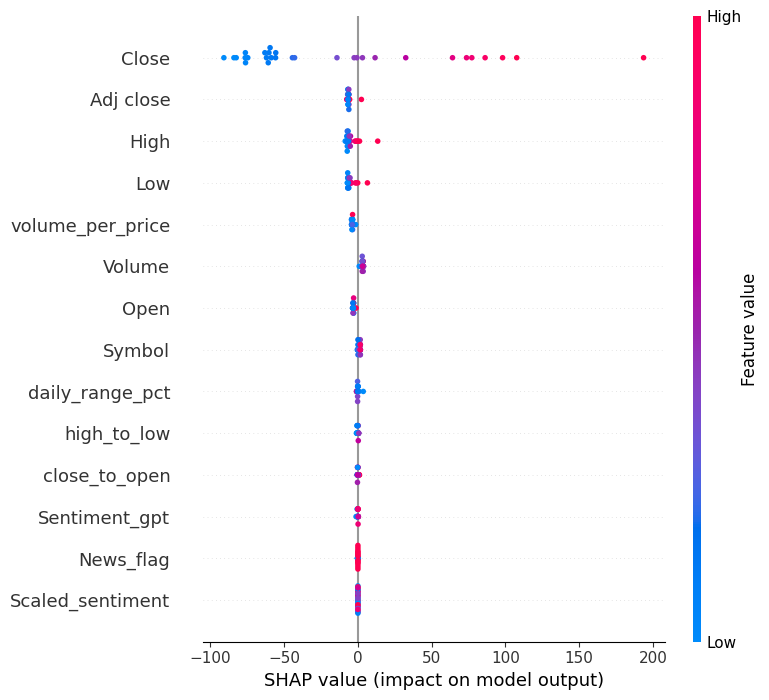


Summary plot for target: High_tomorrow


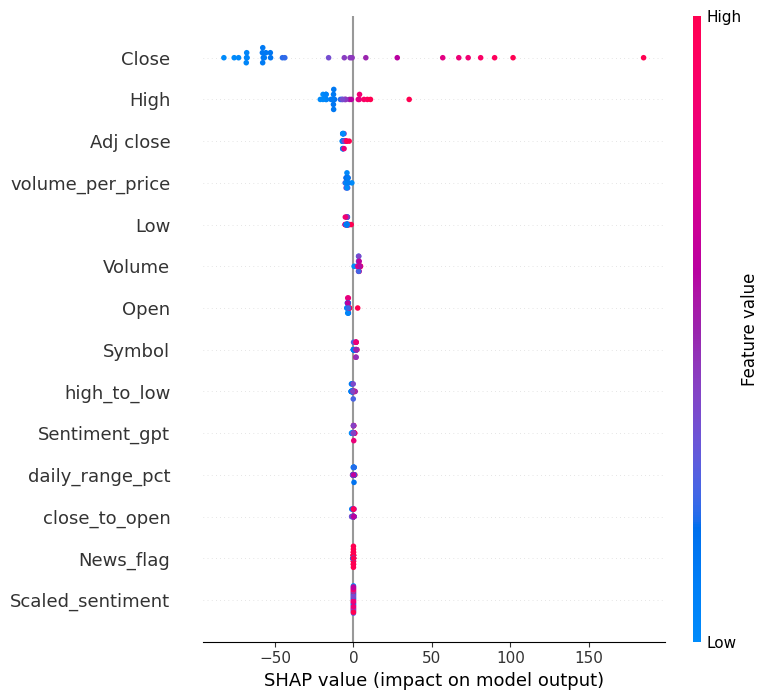


Summary plot for target: Low_tomorrow


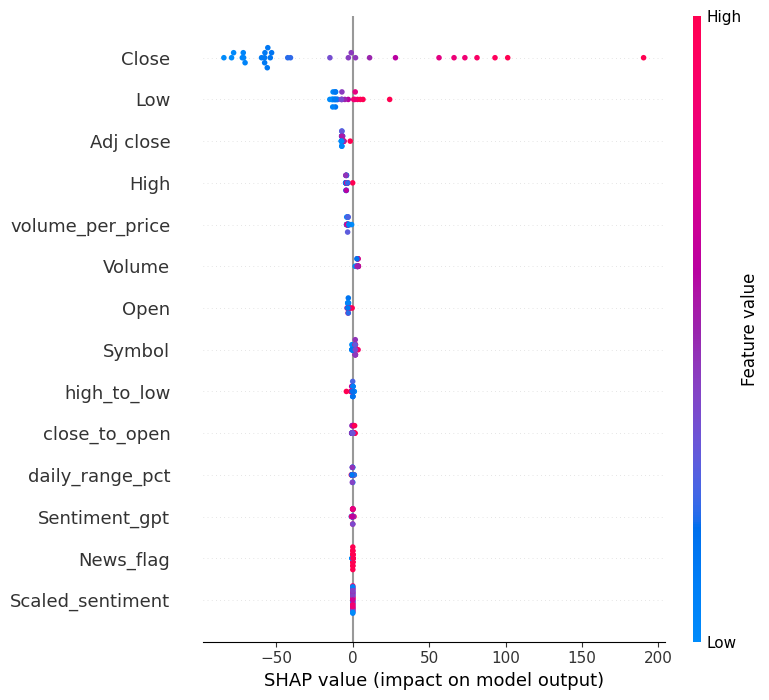


Summary plot for target: Close_tomorrow


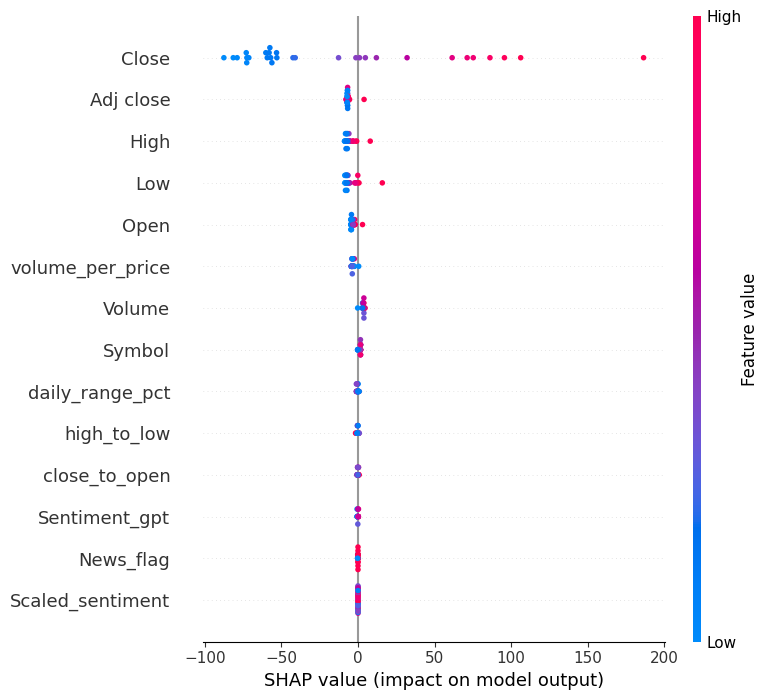


Summary plot for target: Adj close_tomorrow


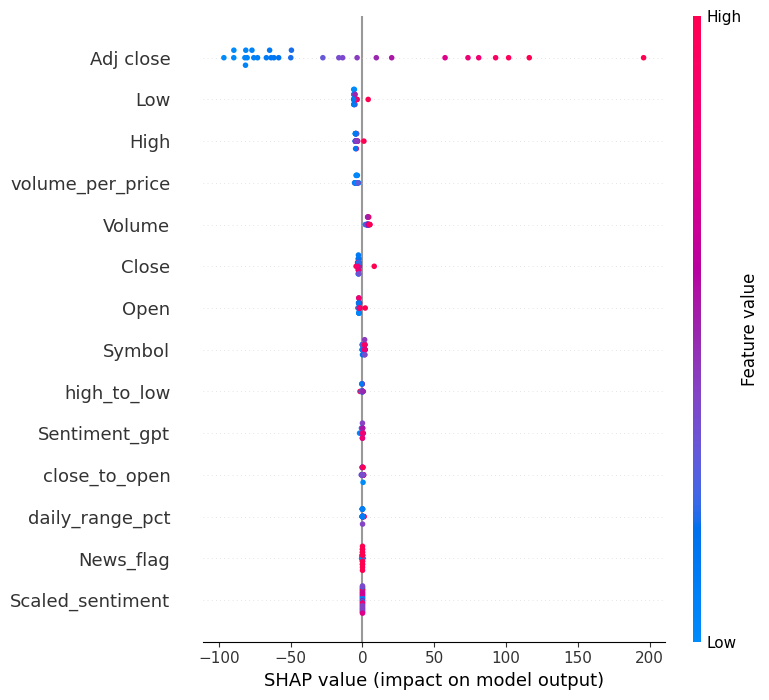

In [95]:
for i, target_name in enumerate(y.columns):
    print(f"\nSummary plot for target: {target_name}")
    explainer = shap.Explainer(multi_xgb.estimators_[i], X_train)
    shap_values = explainer(X_test_sample)

    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=True)


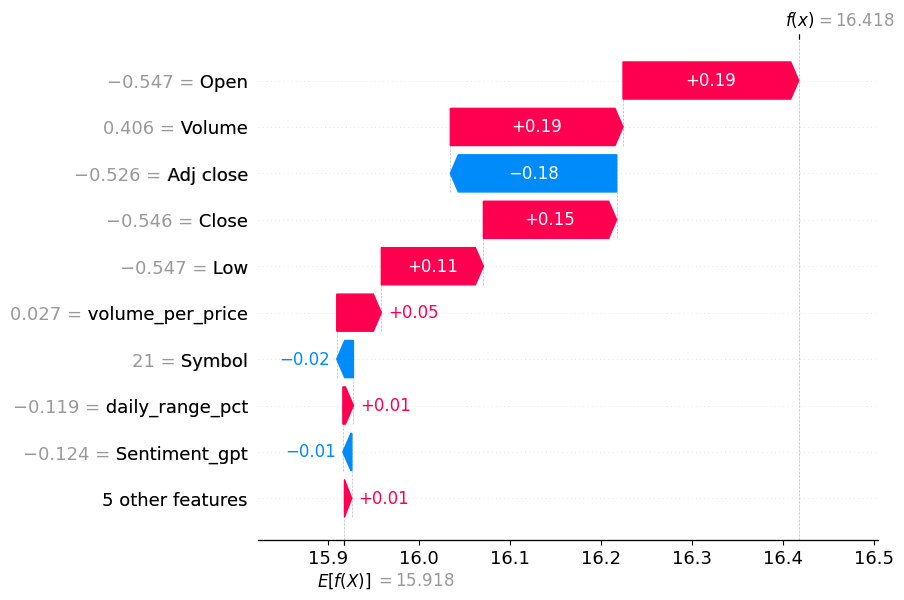

In [96]:
# Explain one sample for the first target
explainer = shap.Explainer(multi_xgb.estimators_[0], X_train)
shap_values = explainer(X_test_sample)

# Waterfall for the first sample
shap.plots.waterfall(shap_values[0])


### PDP

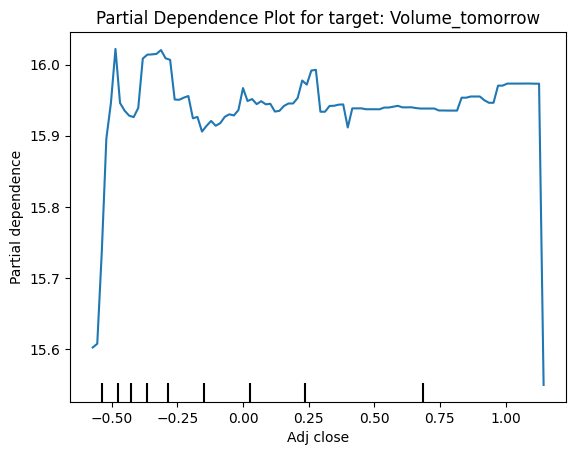

In [98]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

feature_index = 5
target_index = 0

# PDP works on estimator fitted on a single output
estimator = multi_xgb.estimators_[target_index]

# Apply PDP (if X has named columns, you can use feature name instead of index)
disp = PartialDependenceDisplay.from_estimator(
    estimator,
    X,
    features=[feature_index],
    kind="average",
    n_jobs=-1,
    grid_resolution=100
)

plt.title(f'Partial Dependence Plot for target: {y.columns[target_index]}')
plt.show()


this means around flatten, because the range is very very smmall. which means the Adj close didn't have a strong relation with Volume Tomorrow

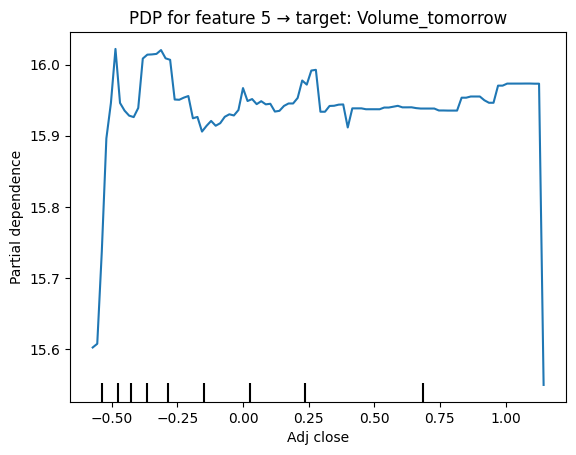

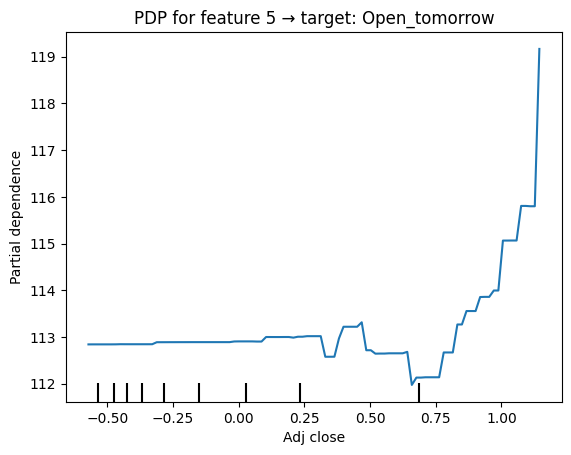

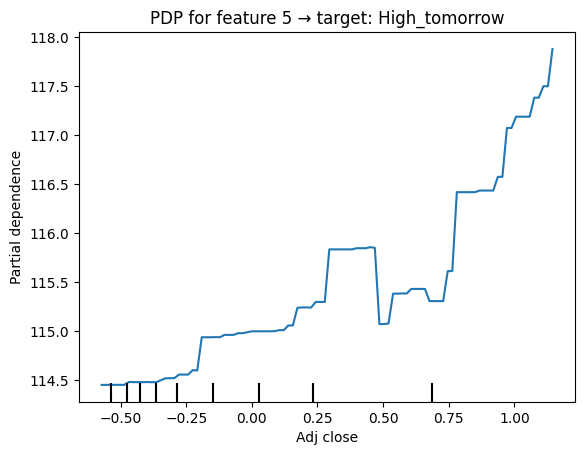

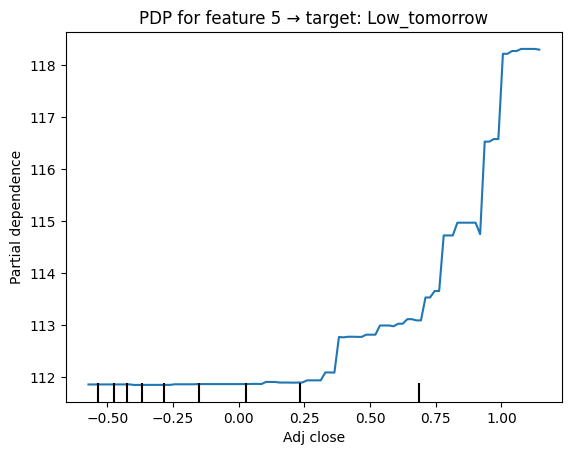

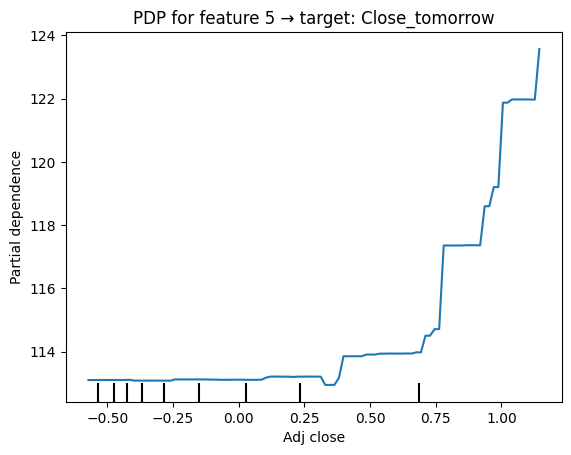

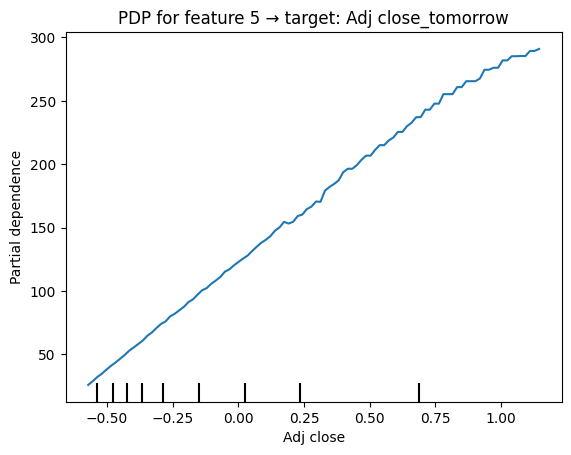

In [99]:
for i, target_name in enumerate(y.columns):
    estimator = multi_xgb.estimators_[i]
    PartialDependenceDisplay.from_estimator(
        estimator, X, features=[feature_index], kind="average"
    )
    plt.title(f"PDP for feature {feature_index} → target: {target_name}")
    plt.show()


### ICE

In [104]:


feature_index = 5
target_index = 0

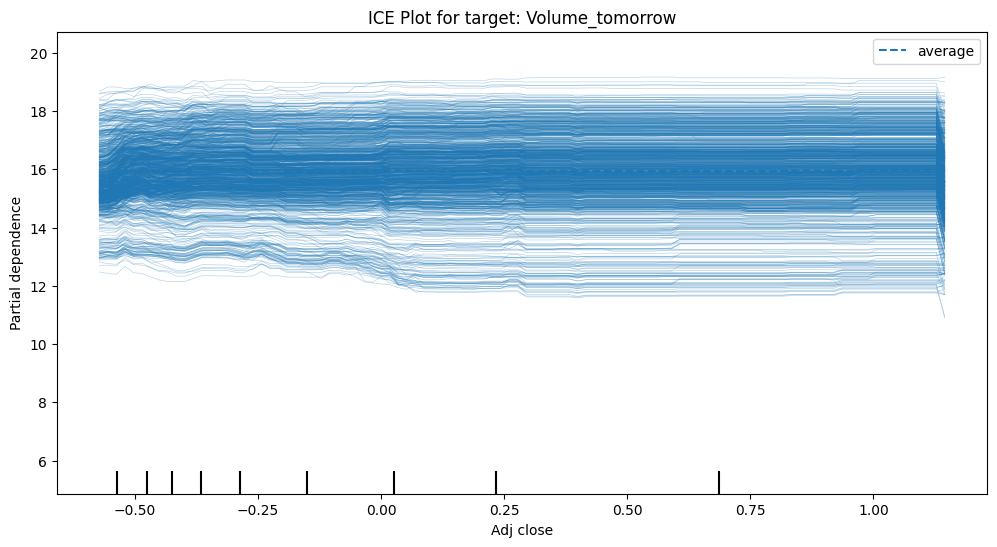

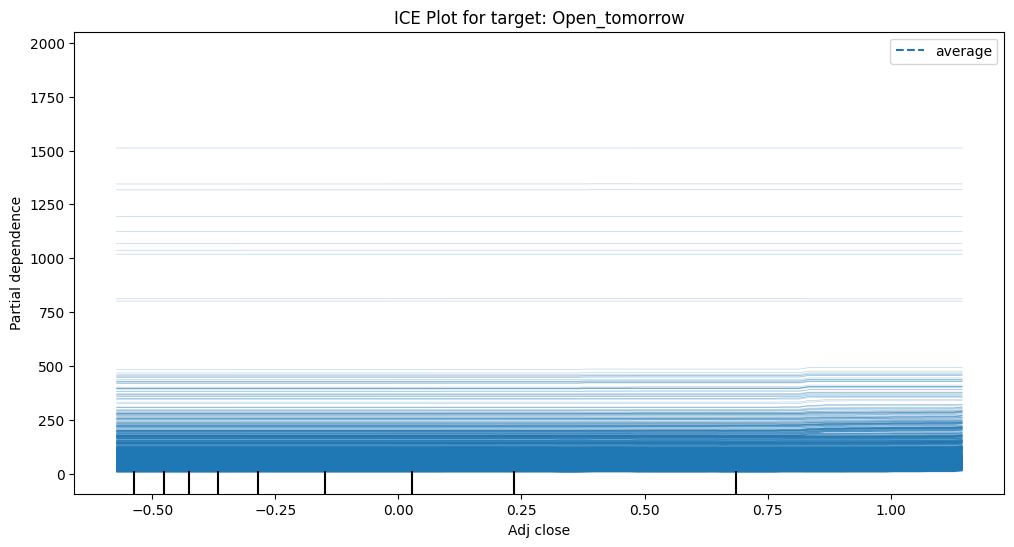

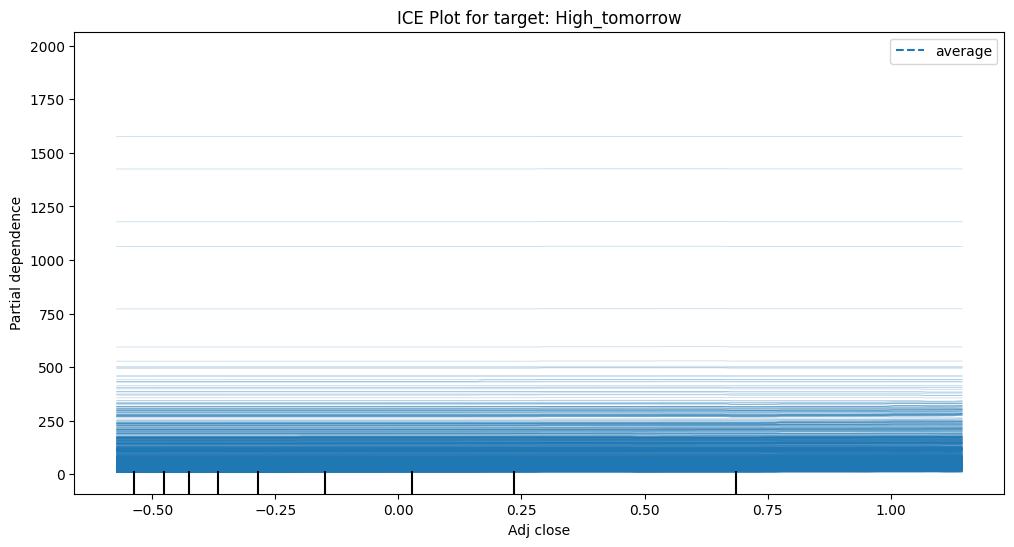

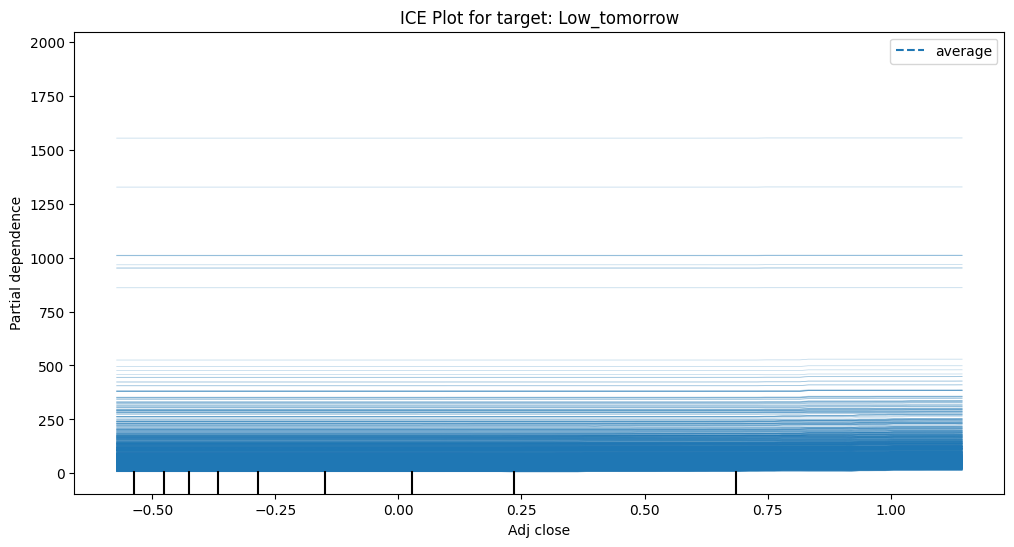

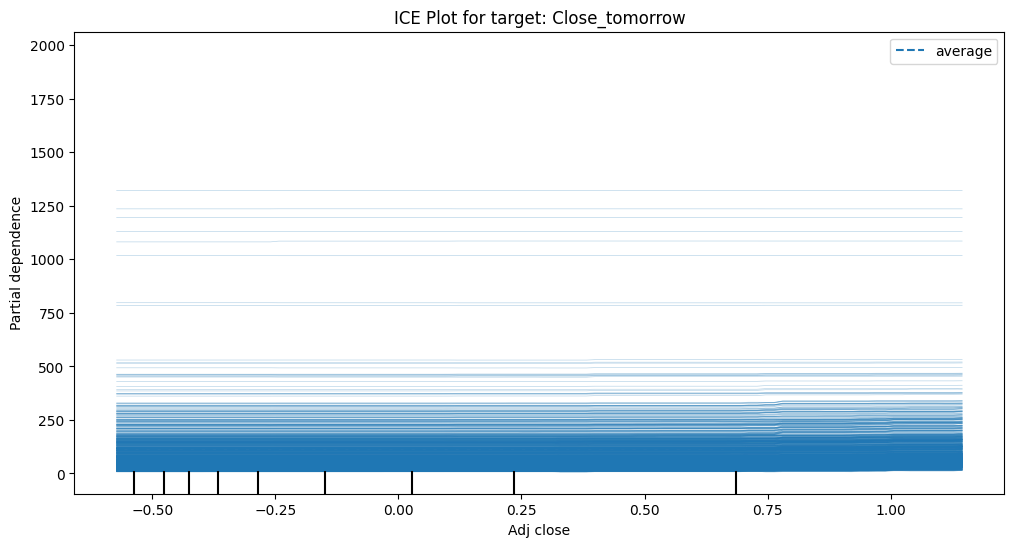

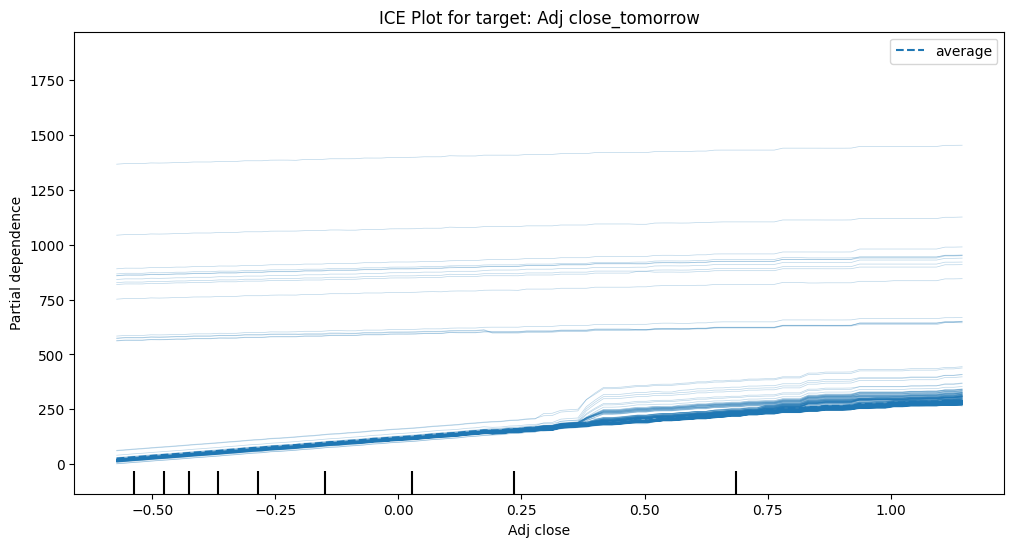

In [105]:
for i, target_name in enumerate(y.columns):
    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        multi_xgb.estimators_[i],
        X,
        features=[feature_index],
        kind='both',
        grid_resolution=100,
        ax=ax
    )
    plt.title(f'ICE Plot for target: {target_name}')
    plt.show()
